In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/Coursework/' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

In [ ]:
### FROM LAB 9 ### 
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset-2.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q CW_Dataset-2.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset-2.zip

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Lambda
import time
import pandas as pd
import copy
from PIL import Image
from skimage import io
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage import data, exposure

%matplotlib inline

In [ ]:
class CustomHOGSDataset(Dataset):

    def __init__(self, annotations_df, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = io.imread(img_path)
        h = image.copy()
        #image = Image.open(img_path)
        #image = torch.from_numpy(image)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        inp = image.numpy().transpose((1, 2, 0))
        HOG_des = hog(inp, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1),block_norm = "L1", multichannel=True)
      
        sample = {"image": image, "label": label, "HOG_des": HOG_des}
        return image, label, HOG_des

In [ ]:
data_dir = "CW_Dataset-2"
l_test = os.path.join(data_dir, "labels", "list_label_test.txt")
d_test = os.path.join(data_dir, "test")
d = os.path.join(data_dir, "train")

In [ ]:
train_lab = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'train_lab.csv'))
train_lab = train_lab.drop(columns='Unnamed: 0')
val_lab = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'val_lab.csv'))
val_lab = val_lab.drop(columns='Unnamed: 0')
test_lab = pd.read_csv(l_test, delimiter= ' ',header=None)
test_lab = test_lab.rename(columns={0: "name", 1: "lbl"})
test_lab['name'] = test_lab['name'].str[:-4] + "_aligned" + ".jpg"
test_lab['lbl'] = test_lab['lbl'] - 1

In [ ]:
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]

training_data = CustomHOGSDataset(train_lab, d, transform=transforms.Compose([transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.RandomRotation(10),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)]))

validation_data = CustomHOGSDataset(val_lab, d, transform=transforms.Compose([transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)]))

test_data = CustomHOGSDataset(test_lab, d_test, transform=transforms.Compose([transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)]))

In [ ]:
class MLP(nn.Module):
    def __init__(
            self,
            hidden_num = 40,
            dropout = 0.1,
            nonlin = torch.nn.Sigmoid()

    
    ):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1152,hidden_num)
        self.fc2 = nn.Linear(hidden_num,8)
        self.non_lin = nonlin
        self.dropout = dropout
        
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.non_lin(hidden)
        output = self.fc2(hidden)
        return output

In [ ]:
ds_train = DataLoader(training_data, batch_size =64, shuffle=True)
ds_val = DataLoader(validation_data, batch_size =64, shuffle=True)
ds_test = DataLoader(test_data, batch_size =1, shuffle=False)

In [ ]:
training_dataset_sizes = len(training_data.img_labels)
training_dataset_sizes

validation_dataset_sizes = len(validation_data.img_labels)
validation_dataset_sizes

test_dataset_sizes = len(test_data.img_labels)
test_dataset_sizes

3068

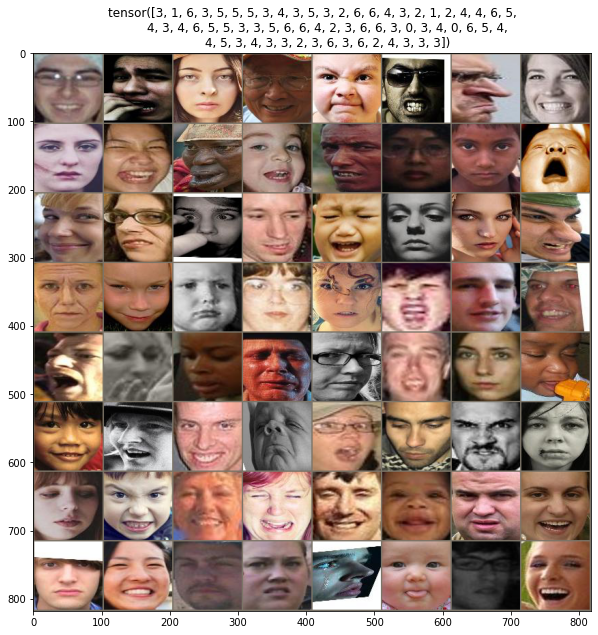

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes, first_hogs = next(iter(ds_val))
#first_inputs, first_classes = sample['image'], sample['label']
# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)

plt.figure(figsize=(10, 15))
imshow(out, title=first_classes)
plt.show()

In [ ]:
### ADAPTED FROM LAB 9 ###
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):
        
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('----------------')

        # Each epoch has a training and validation phase
        
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

            # Iterate over data
        for inputs, labels, desc in ds_train:
       
                # move data to GPU
                desc = desc.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
           
                    outputs = model(desc.float())
                    _, preds = torch.max(outputs, 1)
      
                    
                    loss = criterion(outputs, labels)
             
                    # backward + optimize only if in training phase

                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * desc.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate with scheduler


        epoch_loss = running_loss / training_dataset_sizes
        epoch_acc = running_corrects.double() / training_dataset_sizes

        print(f"train loss: {epoch_loss:.4f} train acc: {epoch_acc:.4f}")
      
        
        model.eval()  # Set model to evaluation mode
        running_loss = 0.0
        running_corrects = 0

        for inputs_val, labels_val, desc_val in ds_val:
                # move data to GPU
                desc_val = desc_val.to(device)
                labels_val = labels_val.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(False):
                    outputs_val = model(desc_val.float())
               
                    _, preds_val = torch.max(outputs_val, 1)
                    loss_val = criterion(outputs_val, labels_val)

                # statistics
                running_loss += loss_val.item() * desc_val.size(0)
                running_corrects += torch.sum(preds_val == labels_val.data)


        epoch_loss = running_loss / validation_dataset_sizes
        epoch_acc = running_corrects.double() / validation_dataset_sizes

        print(f"valid loss: {epoch_loss:.4f} valid acc: {epoch_acc:.4f}")
        


    time_elapsed = time.time() - since

    print(time_elapsed)
    torch.save(model,os.path.join(GOOGLE_DRIVE_PATH,'fin_HOG_MLP.pth'))
    return model

In [ ]:
model = MLP()


model = model.to(device)
    
# Define criterion
criterion = nn.CrossEntropyLoss()
    
    # Configure optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0038958622256026858)
    
    # Train model
best_model= train_model(model, criterion, optimizer, num_epochs=20)

Epoch 0/19
----------------
train loss: 1.5675 train acc: 0.4239
valid loss: 1.4094 valid acc: 0.5055
Epoch 1/19
----------------
train loss: 1.3189 train acc: 0.5236
valid loss: 1.2321 valid acc: 0.5658
Epoch 2/19
----------------
train loss: 1.2229 train acc: 0.5637
valid loss: 1.1825 valid acc: 0.5784
Epoch 3/19
----------------
train loss: 1.1745 train acc: 0.5779
valid loss: 1.1448 valid acc: 0.5870
Epoch 4/19
----------------
train loss: 1.1388 train acc: 0.5928
valid loss: 1.1461 valid acc: 0.5874
Epoch 5/19
----------------
train loss: 1.1236 train acc: 0.5942
valid loss: 1.1141 valid acc: 0.6024
Epoch 6/19
----------------
train loss: 1.1104 train acc: 0.6041
valid loss: 1.1038 valid acc: 0.6045
Epoch 7/19
----------------
train loss: 1.1018 train acc: 0.6019
valid loss: 1.0995 valid acc: 0.6073
Epoch 8/19
----------------
train loss: 1.0990 train acc: 0.6049
valid loss: 1.1044 valid acc: 0.6029
Epoch 9/19
----------------
train loss: 1.0967 train acc: 0.6045
valid loss: 1.070